## Analysis of Portugal's roundabouts

Following the publication of an article in the website discovercars.com about roundabouts, and in order to answer an old question regarding which portuguese city does have the most roundabouts, I've decided to create this python script and get all the roundabouts of the country, therefore answer the following questions :
    - How many roundabouts are in Portugal? And compare the results with Publico's article
    - which city does have the most roundabouts (absolute number)
    - Which city does have the most roundabouts per capita
    - Which city have the most roundabouts per area

### Getting the data
To get the roundabouts, we can easily gather data from Open Street Maps. Using their "Overpass" API allows us to query a server without the need of an ´API key´.

In [13]:
# relevant librairies for getting roundabout's data
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

We can start with the function hat will query the server and create a dataframa with all the roundabouts. For that, we need to send a JSON query, asking for all the junctions called 'roundabout' from a determined place or country.

In [14]:
def get_roundabouts_overpass(place_name):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    area[name="{place_name}"]->.searchArea;
    (
      way["junction"="roundabout"](area.searchArea);
    );
    out center;
    """

    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()

    roundabouts = []
    for element in data['elements']:
        if element['type'] == 'way' and 'center' in element:
            roundabouts.append({
                'Identifier': element['id'],
                'Latitude': element['center']['lat'],
                'Longitude': element['center']['lon'],
                'Country Code': place_name
            })

    return pd.DataFrame(roundabouts)

Now that the function is ready we can execute it for som place, here Portugal, to get the the dataframe with all roundabouts. Then we'll use the ´head()´ function to print out some rows and get a first glimpse of the dataframe.

In [15]:
pt_roundabouts = get_roundabouts_overpass('Portugal')
pt_roundabouts.head()
pt_roundabouts.describe()
pt_roundabouts['Latitude'] = pd.to_numeric(pt_roundabouts['Latitude'], errors='coerce')
pt_roundabouts['Longitude'] = pd.to_numeric(pt_roundabouts['Longitude'], errors='coerce')
pt_roundabouts = pt_roundabouts.dropna(subset=['Latitude', 'Longitude'])


pt_roundabouts.head()

,Identifier,Latitude,Longitude,Country Code
0,3979160,38.972456,-9.419446,Portugal
1,4044459,38.735941,-9.298222,Portugal
2,4044461,38.750924,-9.306044,Portugal
3,4048425,38.983328,-9.417648,Portugal
4,4215045,38.649239,-9.171580,Portugal


To better vizualise the data, we can now plot it in a map of the whole country as below.

/var/folders/bq/2x7yx4v56qbd24ls367ty53w0000gn/T/ipykernel_3564/1735866217.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


There are 18193  unclustered roundabouts in Portugal


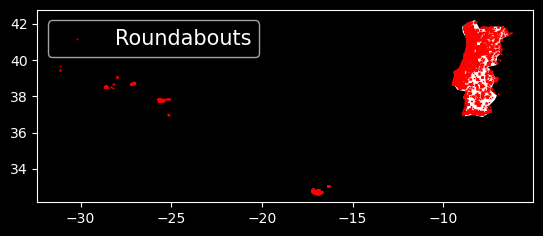

In [16]:
geometry = [Point(xy) for xy in zip(pt_roundabouts.Longitude, pt_roundabouts.Latitude)]
geo_df = gpd.GeoDataFrame(pt_roundabouts, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
portugal = world[world.name == "Portugal"]

fig, ax = plt.subplots()
portugal.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, markersize=0.1, color='red', marker='x', label='Roundabouts')
plt.legend(prop={'size': 15})

unique_roundabout_count = pt_roundabouts['Identifier'].nunique()
print(f"There are {unique_roundabout_count}  unclustered roundabouts in Portugal")

By zooming on the map we have more details, letting us view the density of roundabouts accross the whole country.

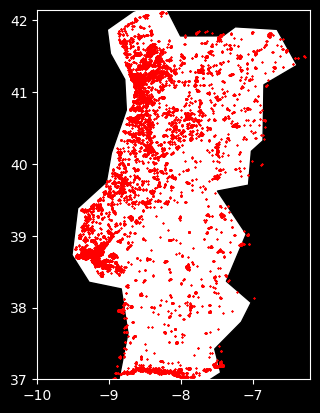

In [17]:
#plot boundaries for Portugal
minx, miny, maxx, maxy = -10.0, 37, -6.2, 42.15

fig, ax = plt.subplots()
portugal.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, markersize=0.5, color='red', marker='x', label='Roundabouts')

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()


By zooming further, to individual roundabouts, we start to observe some flaws with the data. As example, when zooming at "Rotunda da Boavista" in Porto, we can see that what should appear as a single roundabout, is in fact represented by a cluster of several points, as plotted below.

Note. The data provided by OpenStreetMap does suffer from inaccuracies as the definition of roundabout doesn't exactly match the same definition at a governement scale. Some streets does have the appearance of roundabouts, does appear as such in OpenStreetMaps but isn't classified as roundabout by the local governement/authorities.

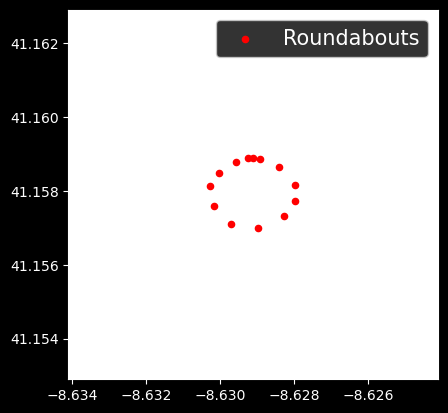

In [18]:
#coodinates of Rotunda da Boavista
lat, lon = 41.1579, -8.6291
delta = 0.005

minx, miny = lon - delta, lat - delta
maxx, maxy = lon + delta, lat + delta

fig, ax = plt.subplots()
portugal.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, markersize=20, color='red', marker='o', label='Roundabouts')

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.legend(prop={'size': 15})
plt.show()

### Cleaning the data
To solve this issue of multiple points, we need to group those points by clusters and then 'collapse' those cluster in a single point. For this purpose, we will use the  "Density-based spatial clustering of applications with noise (DBSCAN) algorithm, with 'haversine' metric to perform the calculation over a sphere (the hearth) using radians. Without modifying the initial data, we can return a new dataframe containing new columns, for individual cluster ids, and the median coordinates of the cluster, allowing the isolated points - out of epsilon radius -  to remain unaffected. The scikit library does contain such algorithm, with sklearn DBSCAN.

In [19]:
from sklearn.cluster import DBSCAN

eps_value_meters = 70  # distance in 'meters', tuned with the plot below
eps_value_radians = eps_value_meters / (6371000.0)  # 6371000 is Earth's radius in meters

def cluster_roundabouts(df, eps_value=eps_value_radians, min_samples=1):

    for col in ['cluster_id', 'cluster_latitude', 'cluster_longitude']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
            
    coords = df[['Latitude', 'Longitude']].values

    db = DBSCAN(eps=eps_value, min_samples=min_samples, algorithm='auto', metric='haversine').fit(np.radians(coords))

    df['cluster_id'] = db.labels_

    cluster_medians = df.groupby('cluster_id')[['Latitude', 'Longitude']].median().rename(columns={'Latitude': 'cluster_latitude', 'Longitude': 'cluster_longitude'})
    
    df = df.join(cluster_medians, on='cluster_id', how='left', rsuffix='_median')

    return df

pt_roundabouts_clustered = cluster_roundabouts(pt_roundabouts)

pt_roundabouts_clustered = pt_roundabouts_clustered[['Country Code', 'cluster_id', 'cluster_latitude', 'cluster_longitude']]
pt_roundabouts_clustered = pt_roundabouts_clustered.drop_duplicates(subset=['cluster_id'])

pt_roundabouts_clustered.head(10)

,Country Code,cluster_id,cluster_latitude,cluster_longitude
0,Portugal,0,38.972456,-9.419542
1,Portugal,1,38.735931,-9.298527
2,Portugal,2,38.750924,-9.306044
3,Portugal,3,38.983340,-9.417913
4,Portugal,4,38.649218,-9.171638
5,Portugal,5,38.646773,-9.169023
6,Portugal,6,38.790145,-9.195447
7,Portugal,7,38.789810,-9.209681
8,Portugal,8,38.774935,-9.097262
9,Portugal,9,38.947119,-8.499644


By plotting again the same roundabout in Porto, we can confirm that the cluster previously representing Porto's roundabout was "collapsed" into a single point, as expected by using the cluster_roundabouts() function.

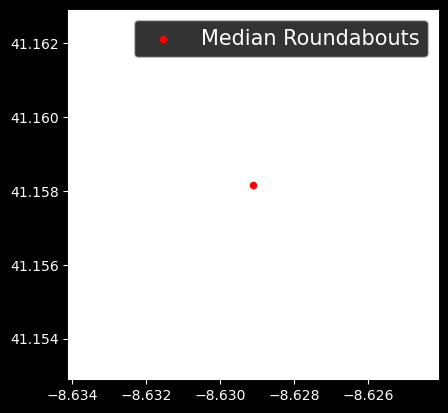

None
EPSG:4326


In [20]:

gdf = gpd.GeoDataFrame(
    pt_roundabouts_clustered, 
    geometry=gpd.points_from_xy(
        pt_roundabouts_clustered['cluster_longitude'], 
        pt_roundabouts_clustered['cluster_latitude']
    )
)

# Coordinates of Rotunda da Boavista
lat, lon = 41.1579, -8.6291
delta = 0.005

minx, miny = lon - delta, lat - delta
maxx, maxy = lon + delta, lat + delta

fig, ax = plt.subplots()
portugal.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=20, color='red', marker='o', label='Median Roundabouts')

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.legend(prop={'size': 15})
plt.show()
print(gdf.crs)
print(portugal.crs)


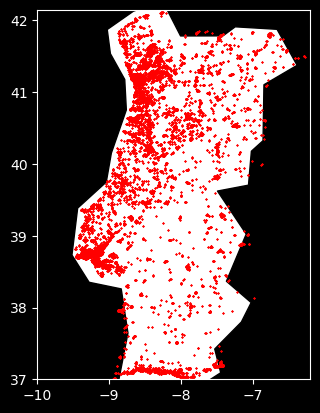

There are 9364 unique roundabouts in Portugal


In [21]:
#plot boundaries
minx, miny, maxx, maxy = -10.0, 37, -6.2, 42.15

fig, ax = plt.subplots()
portugal.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=0.5, color='red', marker='x', label='Roundabouts')

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

unique_roundabout_count = pt_roundabouts_clustered['cluster_id'].nunique()
print(f"There are {unique_roundabout_count} unique roundabouts in Portugal")


We can also see the total number of roundabouts provided by this code : 9354

In [22]:
pt_roundabouts_clustered.tail()

,Country Code,cluster_id,cluster_latitude,cluster_longitude
17994,Portugal,9359,41.250108,-7.308336
17995,Portugal,9360,41.247251,-7.309019
17996,Portugal,9361,40.218827,-8.236078
18177,Portugal,9362,39.361982,-9.393109
18178,Portugal,9363,39.357889,-9.394929


Now, to find the correct city of which each roundabout belongs, we will use Google Maps API to reverse geocode the coordinates.  ```aiohttp``` is used to create the needed asynchronus function and therefore avoid poor performances. Note that in order to re-use this code for your own purpose, you must have your own API key saved in your environment variables. No other API than the one provided by Google was tested for this function.

In [23]:
import asyncio
import aiohttp
import os


async def get_city_async(session, latitude, longitude):
    api_key = os.getenv('GOOGLE_MAPS_API_KEY')
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    complete_url = f"{base_url}?latlng={latitude},{longitude}&key={api_key}"
    
    async with session.get(complete_url) as response:
        if response.status == 200:
            result = await response.json()
            if result['results']:
                for component in result['results'][0]['address_components']:
                    if 'locality' in component['types']:
                        return component['long_name']
                return "City not found in the address components"
            else:
                return "Error: Unable to fetch the address"
        
async def main():
    async with aiohttp.ClientSession() as session:
        tasks = []
        for index, row in pt_roundabouts_clustered.iterrows():
            task = asyncio.ensure_future(get_city_async(session, row['cluster_latitude'], row['cluster_longitude']))
            tasks.append(task)
        cities = await asyncio.gather(*tasks)
        pt_roundabouts_clustered['city'] = cities


                                                                      

In [24]:
await main()

In [25]:
#renaming of the columns for better reading, as
pt_roundabouts_clustered = pt_roundabouts_clustered.rename(columns={
    "cluster_id": "ID",
    "cluster_latitude": "latitude",
    "cluster_longitude": "longitude",
})

pt_roundabouts_clustered.head()

,Country Code,ID,latitude,longitude,city
0,Portugal,0,38.972456,-9.419542,Ericeira
1,Portugal,1,38.735931,-9.298527,Porto Salvo
2,Portugal,2,38.750924,-9.306044,Rio de Mouro
3,Portugal,3,38.983340,-9.417913,Ericeira
4,Portugal,4,38.649218,-9.171638,Almada


In [26]:
pt_roundabouts_clustered.head()

,Country Code,ID,latitude,longitude,city
0,Portugal,0,38.972456,-9.419542,Ericeira
1,Portugal,1,38.735931,-9.298527,Porto Salvo
2,Portugal,2,38.750924,-9.306044,Rio de Mouro
3,Portugal,3,38.983340,-9.417913,Ericeira
4,Portugal,4,38.649218,-9.171638,Almada


In [27]:
pt_roundabouts_clustered.to_csv('Portugal_roundabouts.csv', index=True)

### Cities
To complete our data, we need to attribute the respective city to each roundabout ('cluster_id'). As the 'Overpass' method don't directly provide a city of each point, we need to geocode each roundabout to get their city.

For seak of simplicity of this analysis, we will get the "municipalities" of Portugal to get the list of cities with their relevant information.
We can easily found such list on the dedicated [Wikipedia's article](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_de_Portugal).

A CSV file 'lista_municípios_pt.csv' was created from Wikipedia's article.

In [28]:
pt_cities = pd.read_csv("lista_municípios_pt.csv", delimiter=';', skiprows=1, encoding='utf-8')

pt_cities = pt_cities_2.rename(columns={
    "Município": "city",
    "Código de três letras": "city_code",
    "População em 2021": "population_2021",
    "Area em km^2": "area",
    })

pt_cities = pt_cities.drop(columns=['Unnamed: 4'])


pt_cities.head()

,city,city_code,population_2021,area
0,Abrantes,ABT,34 351,"714,69"
1,Águeda,AGD,46 134,335
2,Aguiar da Beira,AGB,5228,"206,75"
3,Alandroal,ADL,5007,"542,68"
4,Albergaria-a-Velha,ALB,24 841,"158,830"


Now we can combine our two dataframes and get the wanted information, such as "which portugues city does have the most roundabouts (per km2 and per inhabitants)".

In [29]:
roundabouts_count = pt_roundabouts_clustered.groupby('city').size().reset_index(name='roundabouts')
pt_cities = pd.merge(pt_cities, roundabouts_count, on='city', how='left', suffixes=('', '_count'))


pt_cities['roundabouts'] = pd.to_numeric(pt_cities['roundabouts'], errors='coerce')
pt_cities['population_2021'] = pt_cities['population_2021'].str.replace(r'\s+', '', regex=True)
pt_cities['population_2021'] = pd.to_numeric(pt_cities['population_2021'], errors='coerce')
pt_cities['area'] = pt_cities['area'].str.replace(',', '.').astype(float)


pt_cities['rb_per_km2'] = pt_cities['roundabouts'] / pt_cities['area']
pt_cities['rb_per_inhabitant'] = pt_cities['roundabouts'] / pt_cities['population_2021']


pt_cities.head()

,city,city_code,population_2021,area,roundabouts,rb_per_km2,rb_per_inhabitant
0,Abrantes,ABT,34351,714.69,10.0,0.013992,0.000291
1,Águeda,AGD,46134,335.00,10.0,0.029851,0.000217
2,Aguiar da Beira,AGB,5228,206.75,2.0,0.009674,0.000383
3,Alandroal,ADL,5007,542.68,1.0,0.001843,0.000200
4,Albergaria-a-Velha,ALB,24841,158.83,20.0,0.125921,0.000805


Here, the same with "cities with the biggest number of roundabouts".

In [30]:
sorted_rb_per_city = pt_cities.sort_values(by='roundabouts', ascending=False)
sorted_rb_per_city.head(10)

,city,city_code,population_2021,area,roundabouts,rb_per_km2,rb_per_inhabitant
78,Coimbra,CBR,140796,319.40,72.0,0.225423,0.000511
67,Castelo Branco,CTB,52272,1438.19,54.0,0.037547,0.001033
24,Amadora,AMD,171719,23.79,48.0,2.017654,0.000280
124,Lisboa,LSB,544851,100.05,44.0,0.439780,0.000081
5,Albufeira,ABF,44158,140.66,43.0,0.305702,0.000974
305,Viseu,VIS,99693,507.10,39.0,0.076908,0.000391
208,Portimão,PTM,59896,182.06,38.0,0.208722,0.000634
112,Guarda,GRD,40155,712.10,34.0,0.047746,0.000847
65,Cascais,CSC,214134,97.40,32.0,0.328542,0.000149
51,Braga,BRG,193333,183.40,32.0,0.174482,0.000166


Below, the top 10 cities with most roundabout per km2

In [31]:
sorted_rb_per_km2 = pt_cities.sort_values(by='rb_per_km2', ascending=False)
sorted_rb_per_km2.head(10)


,city,city_code,population_2021,area,roundabouts,rb_per_km2,rb_per_inhabitant
239,São João da Madeira,SJM,22162,7.94,23.0,2.896725,0.001038
24,Amadora,AMD,171719,23.79,48.0,2.017654,0.000280
174,Odivelas,ODV,148156,26.54,16.0,0.602864,0.000108
124,Lisboa,LSB,544851,100.05,44.0,0.439780,0.000081
209,Porto,PRT,231962,41.42,14.0,0.338001,0.000060
88,Espinho,ESP,31027,21.06,7.0,0.332384,0.000226
65,Cascais,CSC,214134,97.40,32.0,0.328542,0.000149
5,Albufeira,ABF,44158,140.66,43.0,0.305702,0.000974
78,Coimbra,CBR,140796,319.40,72.0,0.225423,0.000511
208,Portimão,PTM,59896,182.06,38.0,0.208722,0.000634


In [32]:
sorted_rb_per_inhabitant = pt_cities.sort_values(by='rb_per_inhabitant', ascending=False)
sorted_rb_per_inhabitant.head(10)

,city,city_code,population_2021,area,roundabouts,rb_per_km2,rb_per_inhabitant
165,Mourão,MOU,2353,278.63,4.0,0.014356,0.001700
303,Vimioso,VMS,4154,481.59,7.0,0.014535,0.001685
101,Fornos de Algodres,FAG,4398,131.45,7.0,0.053252,0.001592
84,Crato,CRT,3225,398.07,5.0,0.012561,0.001550
283,Vila de Rei,VLR,3276,191.55,5.0,0.026103,0.001526
14,Aljezur,AJZ,6046,323.50,9.0,0.027821,0.001489
72,Castro Verde,CVR,6878,569.44,10.0,0.017561,0.001454
103,Fronteira,FTR,2856,248.60,4.0,0.016090,0.001401
295,Vila Nova de Paiva,VNP,4660,175.53,6.0,0.034182,0.001288
162,Mora,MOR,4128,443.95,5.0,0.011263,0.001211


In [33]:
pt_cities.to_csv('pt_cities_rb.csv', index=True)

For a better vizualisation of this data on a map, you can visit the Tableau created for it at https://public.tableau.com/app/profile/diogo.freire7485/viz/Portugueseroundabouts/Dashboard1?publish=yes